# Améliorez le produit IA de votre start-up

## Traitement des commentaires

In [1]:
import os
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import operator
from nltk.stem.snowball import EnglishStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.classify import NaiveBayesClassifier
import gensim
from gensim.models import Word2Vec
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

# nltk.download()

debug = 1

if debug:
    nrows = 100000
else:
    nrows = None

In [2]:
filename = './yelp_dataset/yelp_academic_dataset_review.json' 
comments = pd.read_json(filename, lines=True, nrows=nrows)

In [3]:
comments.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,lWC-xP3rd6obsecCYsGZRg,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4,3,1,1,"Apparently Prides Osteria had a rough summer as evidenced by the almost empty dining room at 6:30 on a Friday night. However new blood in the kitchen seems to have revitalized the food from other customers recent visits. Waitstaff was warm but unobtrusive. By 8 pm or so when we left the bar was full and the dining room was much more lively than it had been. Perhaps Beverly residents prefer a later seating. \n\nAfter reading the mixed reviews of late I was a little tentative over our choice but luckily there was nothing to worry about in the food department. We started with the fried dough, burrata and prosciutto which were all lovely. Then although they don't offer half portions of pasta we each ordered the entree size and split them. We chose the tagliatelle bolognese and a four cheese filled pasta in a creamy sauce with bacon, asparagus and grana frita. Both were very good. We split a secondi which was the special Berkshire pork secreto, which was described as a pork skirt steak with garlic potato purée and romanesco broccoli (incorrectly described as a romanesco sauce). Some tables received bread before the meal but for some reason we did not. \n\nManagement also seems capable for when the tenants in the apartment above began playing basketball she intervened and also comped the tables a dessert. We ordered the apple dumpling with gelato and it was also quite tasty. Portions are not huge which I particularly like because I prefer to order courses. If you are someone who orders just a meal you may leave hungry depending on you appetite. Dining room was mostly younger crowd while the bar was definitely the over 40 set. Would recommend that the naysayers return to see the improvement although I personally don't know the former glory to be able to compare. Easy access to downtown Salem without the crowds on this month of October.",2014-10-11 03:34:02
1,8bFej1QE5LXp4O05qjGqXA,YoVfDbnISlW0f7abNQACIg,RA4V8pr014UyUbDvI-LW2A,4,1,0,0,"This store is pretty good. Not as great as Walmart (or my preferred, Milford Target), but closer and in a easier area to get to. \nThe store itself is pretty clean and organized, the staff are friendly (most of the time), and BEST of all is the Self Checkout this store has! \nGreat clearance sections throughout, and great prices on everything in the store, in general (they pricematch too!). \nChristian, Debbie, Jen and Hanna are all very friendly, helpful, sensitive to all customer needs. Definitely one of the better Target locations in the area, and they do a GREAT job assisting customers for being such a busy store. Located directly in the Framingham Mall on Cochituate Rd / Route 30. 4 stars.",2015-07-03 20:38:25
2,NDhkzczKjLshODbqDoNLSg,eC5evKn1TWDyHCyQAwguUw,_sS2LBIGNT5NQb6PD1Vtjw,5,0,0,0,"I called WVM on the recommendation of a couple of friends who had used them in the past and thought they did a nice job. I'm a fan now, too.\n\nEvan and Cody showed up right on time for my move this past weekend. They were friendly and energetic, working quickly but carefully to get all my things moved out of the old place and into the new one in less than 2.5 hours. All of my (heavy) furniture arrived in perfect condition, and they took extra care not to scratch the wood floors in the process.\n\nI hope not to move again anytime soon, but next time I do, I'll be calling WVM.",2013-05-28 20:38:06
3,T5fAqjjFooT4V0OeZyuk1w,SFQ1jcnGguO0LYWnbbftAA,0AzLzHfOJgL7ROwhdww2ew,2,1,1,1,I've stayed at many Marriott and Renaissance Marriott's and this was a huge disappointment! The front desk and atrium is nice..there is a starbucks on site which is nice.\n\nThe rooms are run down and old. There is a flat screen but that is to be expected of a Renaissance.\n\nWe got this hotel via Priceline at a rate of $75/night...good deal for the price but this is not a true Renaissance.,2010-01-08 

In [4]:
nrows = len(comments["text"].to_list())

### Baseline

In [5]:
stemmer = EnglishStemmer()
tokenizer = nltk.RegexpTokenizer(r'\w+')
stop_words = [stemmer.stem(w) for w in list(nltk.corpus.stopwords.words('english'))]


def clean_up(text):
    tokens = tokenizer.tokenize(text)
    tokens = [stemmer.stem(w) for w in tokens]
    tokens = [w for w in tokens if not w in stop_words]
    return tokens

# print(clean_up("Hey, I'm an example text for OpenClassrooms course. Please pay attention !"))

In [6]:
tokenized_text = [*map(clean_up, comments["text"].to_list())]

In [7]:
freqs = {}
for comment in tokenized_text:
    for word in list(set(comment)):
        if word in freqs:
            freqs[word] += 1
        else:
            freqs[word] = 1

freqs_list = [(x, freqs[x]/nrows)for x in freqs]
freqs_list = sorted(freqs_list, key=lambda x:x[1])[::-1]
print(freqs_list[:10])

[('place', 0.3789), ('food', 0.36111), ('good', 0.35824), ('great', 0.32517), ('time', 0.2855), ('go', 0.28411), ('servic', 0.28208), ('get', 0.27166), ('like', 0.26921), ('one', 0.23937)]


In [8]:
# Create CBOW model
model1 = gensim.models.Word2Vec(tokenized_text, min_count = 1, vector_size = 100, window = 5)

In [9]:
text = [' '.join(comment) for comment in tokenized_text]

In [10]:
n_topics = 10

tf_vectoriser = CountVectorizer(max_df=.6, min_df=10, max_features=100)
tf = tf_vectoriser.fit_transform(text)

lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=42).fit(tf)


In [11]:
def display_topics(model, feature_names, ntw): # do multiple runs and hyperparameters optimization
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-ntw - 1:-1]]))

n_top_words = 10
display_topics(lda, tf_vectoriser.get_feature_names(), n_top_words)

Topic 0:
servic call custom ask said would back hour could never
Topic 1:
chicken order fri flavor tast good sauc dish tri like
Topic 2:
food good great servic place realli fresh pretti eat delici
Topic 3:
us restaur tabl food experi came servic even ask one
Topic 4:
day time work need one locat visit help new first
Topic 5:
great recommend friend definit nice price back place staff would
Topic 6:
drink bar night best place one ever area friend great
Topic 7:
love alway great amaz place best friend perfect go staff
Topic 8:
like get go place one realli good want time look
Topic 9:
order wait pizza time minut food get go take place


In [12]:
features_names = tf_vectoriser.get_feature_names()

In [13]:
words_df = pd.DataFrame(columns=features_names, data=tf.toarray())
for col_name in features_names:
    words_df[col_name] = words_df[col_name].astype('bool')
words_df.head()

,also,alway,amaz,area,around,ask,back,bar,best,better,busi,call,came,chicken,come,could,custom,day,definit,delici,dish,drink,eat,even,ever,everyth,experi,feel,first,flavor,food,fresh,fri,friend,get,give,go,good,got,great,help,hour,know,like,littl,locat,look,lot,love,made,make,menu,minut,much,need,never,new,nice,night,one,order,peopl,perfect,pizza,place,pretti,price,realli,recommend,restaur,review,right,said,sauc,say,see,servic,staff,star,still,sure,tabl,take,tast,thing,think,time,tri,two,us,use,visit,wait,want,way,well,went,work,would,year
0,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,True,True,True,False,False,False,True,False,False,False,False,True,False,False,True,False,True,False,True,False,False,False,False,False,False,False,True,False,True,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False
1,False,False,False,True,False,False,False,False,True,True,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True,False,False,True,False,True,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False,False,True,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False


In [14]:
from sklearn.linear_model import BayesianRidge

y = comments['stars']
X = words_df
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

reg = BayesianRidge()
reg.fit(X_train, y_train)


BayesianRidge()

In [15]:
score = reg.score(X_test, y_test)
importance = reg.coef_

In [16]:
print(score)

0.32510238008153713


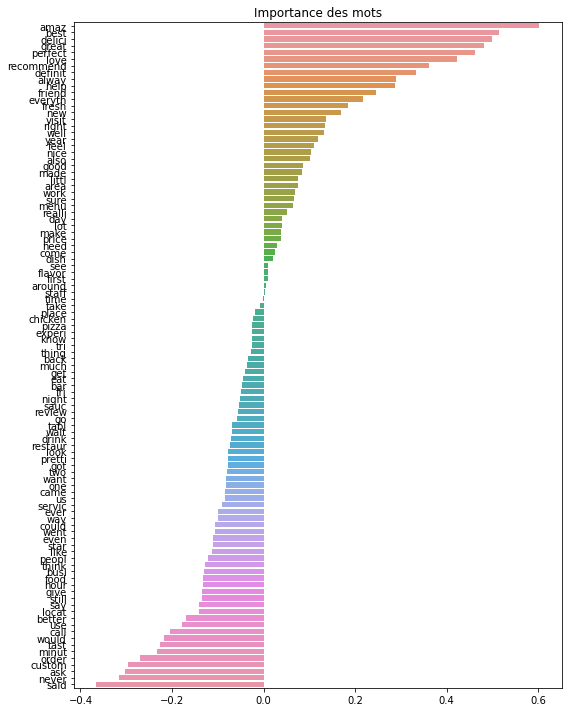

In [17]:
def display_imp(feature_importance):
    ordered_features, ordered_importance = [list(i) for i in zip(*sorted(zip(features_names, feature_importance), key=lambda x: -x[1]))]
    plt.figure(figsize=(8, 10))
    sns.barplot(x=ordered_importance, y=ordered_features)
    plt.title(f'Importance des mots')
    plt.tight_layout()
    plt.show()

display_imp(importance)